In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [3]:
# 1. 상수 정의
BATCH_SIZE = 32
IMG_SIZE = 224

In [4]:
# 2. 데이터 로드
(raw_train, raw_val, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)
class_names = metadata.features['label'].names

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.K7HNIT_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [5]:
# 3. 전처리 & 증강
def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    k = tf.random.uniform([], 0, 4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    crop_size = tf.random.uniform([], int(0.8*IMG_SIZE), IMG_SIZE, dtype=tf.int32)
    image = tf.image.random_crop(image, [crop_size, crop_size, 3])
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image, label

In [6]:
# 4. 데이터 배치 준비
train_batches = (
    raw_train
    .map(format_image, tf.data.AUTOTUNE)
    .map(augment, tf.data.AUTOTUNE)
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
validation_batches = raw_val.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_batches       = raw_test.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
# 5. 모델 구성 (Fine‑tuning)
base_model = VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                   include_top=False, weights='imagenet')
base_model.trainable = True
for layer in base_model.layers:
    layer.trainable = layer.name.startswith('block5_')

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# 6. 컴파일 & 학습
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history = model.fit(
    train_batches,
    epochs=15,
    validation_data=validation_batches
)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 57s 408ms/step - accuracy: 0.3293 - loss: 1.9624 - val_accuracy: 0.5858 - val_loss: 1.2114
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 206ms/step - accuracy: 0.5909 - loss: 1.2183 - val_accuracy: 0.7275 - val_loss: 0.8354
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 208ms/step - accuracy: 0.6788 - loss: 0.9585 - val_accuracy: 0.7711 - val_loss: 0.6662
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 221ms/step - accuracy: 0.7345 - loss: 0.7855 - val_accuracy: 0.7875 - val_loss: 0.5793
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 218ms/step - accuracy: 0.7432 - loss: 0.7730 - val_accuracy: 0.8120 - val_loss: 0.5575
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 229ms/step - accuracy: 0.7627 - loss: 0.6851 - val_accuracy: 0.8174 - val_loss: 0.5407
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 224ms/step - accuracy: 0.8078 - loss: 0.5693 - val_accuracy: 0.8311 - val_loss: 0.4985
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 220ms/step - accuracy: 0.8099 - loss: 0.5530 - val_accu

In [9]:
# 7. 테스트 세트 성능 평가
test_loss, test_acc = model.evaluate(test_batches)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.8858 - loss: 0.3247
Test Loss: 0.3338
Test Accuracy: 88.56%


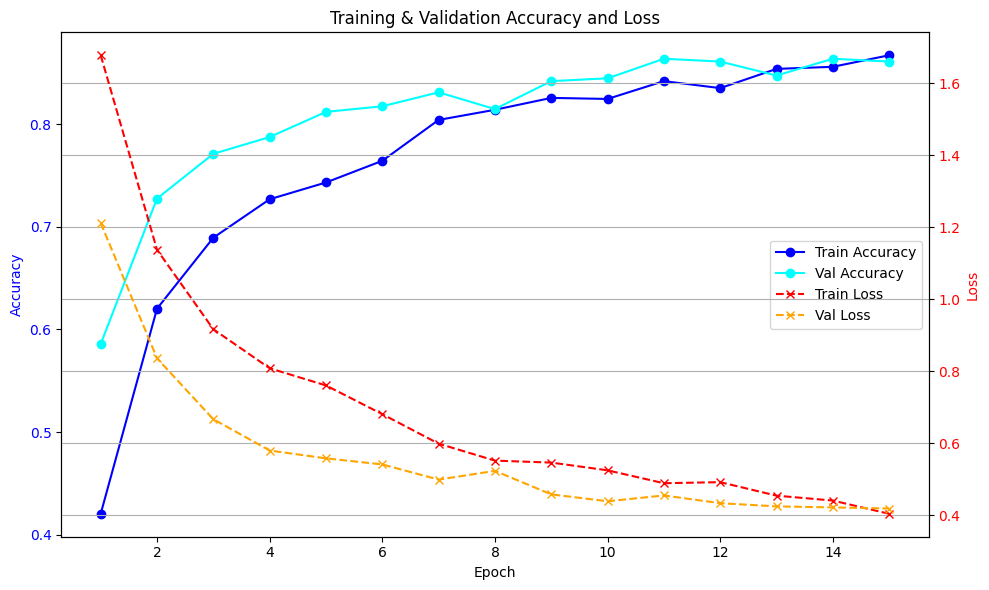

In [10]:
# 8. 결과 시각화
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['accuracy']) + 1)

fig, ax1 = plt.subplots(figsize=(10, 6))

# 정확도 (왼쪽 y축)
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy', color='blue', marker='o')
ax1.plot(epochs, history.history['val_accuracy'], label='Val Accuracy', color='cyan', marker='o')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 손실 (오른쪽 y축)
ax2 = ax1.twinx()
ax2.plot(epochs, history.history['loss'], label='Train Loss', color='red', linestyle='--', marker='x')
ax2.plot(epochs, history.history['val_loss'], label='Val Loss', color='orange', linestyle='--', marker='x')
ax2.set_ylabel('Loss', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# 합치기
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='center right')

plt.title('Training & Validation Accuracy and Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

# <결과 분석>

훈련 정확도 (epoch 15): 86.18%

검증 정확도 (epoch 15): 86.10%

훈련 손실 vs 검증 손실도 꾸준히 같이 떨어짐.

## 과적합 거의 없음

Test Accuracy: 88.58%

Validation Accuracy(최종): 86.10%

## 일반적으로 모델이 잘 일반화됨

## 강화된 증강과 일부 레이어 미세조정, 규제를 추가
## => 과적합이 크게 줄고 테스트 성능도 유의미하게 올랐음

### 과적합 감소

원래 실험에선 훈련 정확도가 98%까지 올라가고 검증 정확도는 82%에 머물러 두 지표 차이가 컸음

개선 실험에선 훈련/검증 정확도가 거의 일치(86.18% vs 86.10%)하며 과적합이 거의 사라졌음

### 일반화 성능 향상

원래 실험의 Test Acc 83.23% → 개선 후 88.58%로 약 +5.3%p 상승함

### 안정적인 수렴

원래 실험의 val_loss가 중반 이후 들쑥날쑥했던 반면, 개선 실험에선 val_loss가 점진적으로 안정적으로 감소함